In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import csv
import sys
#from sklearn.metrics import mean_squared_error
import math
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.engine.topology import Layer
from matplotlib.pyplot import axis
import formatDataSet
import transformations as Transformation

Using TensorFlow backend.


Running Main FormatDataSet.py ... 

======> Purpose is to Generate Per Subject Models ... 

Reading the Subject Pickle File ... 
  .\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle
.\Datasets\2016-5-5-13-7\DataSet_All.pickle
.\Datasets\2016-5-5-13-7\trialType_All.pickle


C:\Users\kb4000\Documents\Python\modellingbyrnn\transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
pickleFileName = r'.\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle'

print('Reading the Subject Pickle File ... \n ', pickleFileName)
eyeToScreenDistance = 0.0725
ballDiameter = 0.01
df = pd.read_pickle(pickleFileName)
print('Raw Dataset Read in!')
rawDataFrame = df['raw']
processedDataFrame = df['processed']
calibDataFrame = df['calibration']
trialInfoDataFrame = df['trialInfo']


Reading the Subject Pickle File ... 
  .\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle
Raw Dataset Read in!


In [3]:
list(processedDataFrame.columns)

[('paddleFaceDir', 'X'),
 ('paddleFaceDir', 'Y'),
 ('paddleFaceDir', 'Z'),
 ('paddleUpDir', 'X'),
 ('paddleUpDir', 'Y'),
 ('paddleUpDir', 'Z'),
 ('paddlFaceLatDir', 'X'),
 ('paddlFaceLatDir', 'Y'),
 ('paddlFaceLatDir', 'Z'),
 ('paddleToBallVec', 'X'),
 ('paddleToBallVec', 'Y'),
 ('paddleToBallVec', 'Z'),
 ('paddleToBallDir', 'X'),
 ('paddleToBallDir', 'Y'),
 ('paddleToBallDir', 'Z'),
 ('paddleToBallDirXZ', 'X'),
 ('paddleToBallDirXZ', 'Y'),
 ('paddleToBallDirXZ', 'Z'),
 ('paddleToBallLatDirXZ', 'X'),
 ('paddleToBallLatDirXZ', 'Y'),
 ('paddleToBallLatDirXZ', 'Z'),
 ('eventFlag', ''),
 ('frameTime', ''),
 ('trialNumber', ''),
 ('viewQuat', 'X'),
 ('viewQuat', 'Y'),
 ('viewQuat', 'Z'),
 ('viewQuat', 'W'),
 ('medFilt3_cycEyeOnScreen', 'X'),
 ('medFilt3_cycEyeOnScreen', 'Y'),
 ('medFilt5_cycEyeOnScreen', 'X'),
 ('medFilt5_cycEyeOnScreen', 'Y'),
 ('medFilt7_cycEyeOnScreen', 'X'),
 ('medFilt7_cycEyeOnScreen', 'Y'),
 ('avgFilt3_cycEyeOnScreen', 'X'),
 ('avgFilt3_cycEyeOnScreen', 'Y'),
 ('avgFi

In [4]:
handHeadPos = rawDataFrame.paddlePos - rawDataFrame.viewPos
#handHeadPos

In [5]:

eyeToScreenDistance = 0.0725
myX = (180 / np.pi) * np.arctan(handHeadPos.X.values.astype(float) / handHeadPos.Z.values.astype(float))
myY = (180 / np.pi) * np.arctan(handHeadPos.Y.values.astype(float) / handHeadPos.Z.values.astype(float))
myZ = np.sqrt(np.power(handHeadPos.X.values.astype(float),2) + np.power(handHeadPos.Y.values.astype(float),2) + np.power(handHeadPos.Z.values.astype(float),2))
processedDataFrame.loc[:, ('handAngularPos', 'X')] = myX
processedDataFrame.loc[:, ('handAngularPos', 'Y')] = myY
processedDataFrame.loc[:, ('handAngularPos', 'Z')] = myZ


In [6]:
print(processedDataFrame.handAngularPos[0:20])

            X          Y         Z
0   34.036887 -29.892822  0.460711
1   34.036893 -29.973016  0.461209
2   33.704900 -30.070688  0.462032
3   33.549657 -30.215452  0.462541
4   33.539308 -30.291049  0.462601
5   33.710833 -30.346428  0.462454
6   33.638639 -30.401591  0.462493
7   33.276353 -30.369012  0.462116
8   33.005572 -30.367114  0.462265
9   32.899078 -30.198483  0.461836
10  32.980332 -29.907207  0.461218
11  32.731054 -29.769916  0.459795
12  32.245931 -29.597331  0.458909
13  32.119036 -29.384949  0.457281
14  31.772912 -29.215705  0.455291
15  31.833261 -28.841339  0.453327
16  31.516704 -28.701311  0.450720
17  31.053278 -28.557243  0.449086
18  30.863562 -28.371644  0.447263
19  30.571312 -28.279872  0.445448


In [7]:
x = (180 / np.pi)*np.arctan(processedDataFrame.rotatedBallOnScreen.X.values.astype(float)/eyeToScreenDistance)
y = (180 / np.pi)*np.arctan(processedDataFrame.rotatedBallOnScreen.Y.values.astype(float)/eyeToScreenDistance)
xg = (180 / np.pi)*np.arctan(processedDataFrame.rotatedGazePoint.X.values.astype(float)/eyeToScreenDistance)
yg = (180 / np.pi)*np.arctan(processedDataFrame.rotatedGazePoint.Y.values.astype(float)/eyeToScreenDistance)

x = (180 / np.pi)*np.arctan(processedDataFrame.ballOnScreen.X.values.astype(float)/processedDataFrame.ballOnScreen.Z.values.astype(float))
y = (180 / np.pi)*np.arctan(processedDataFrame.ballOnScreen.Y.values.astype(float)/processedDataFrame.ballOnScreen.Z.values.astype(float))
xg = (180 / np.pi)*np.arctan(processedDataFrame.gazePoint.X.values.astype(float)/processedDataFrame.gazePoint.Z.values.astype(float))
yg = (180 / np.pi)*np.arctan(processedDataFrame.gazePoint.Y.values.astype(float)/processedDataFrame.gazePoint.Z.values.astype(float))

True
601
703
0.771327471502


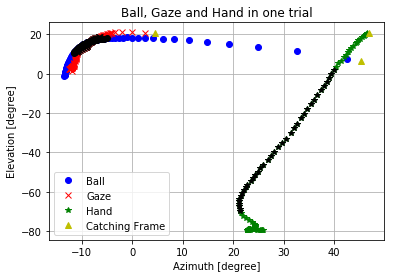

In [8]:
trialNumber = 2
Q = trialInfoDataFrame.ballCaughtQ.values[trialNumber]
print(Q)
start = trialInfoDataFrame.trialStartIdx.values[trialNumber]
print(start)
end = trialInfoDataFrame.ballCrossingIndex.values[trialNumber]
print(end)
print(processedDataFrame.handAngularPos.Z.values[end])

frameRange = range(start,end)
plt.figure()
#plt.errorbar(x, meanHandX, yerr=stdHandX, fmt='--bo', ecolor='b', label = 'Hand X')
plt.plot(x[frameRange], y[frameRange],'ob', label = 'Ball')
plt.plot(xg[frameRange], yg[frameRange],'xr', label = 'Gaze')
plt.plot(processedDataFrame.handAngularPos.X.values[frameRange], processedDataFrame.handAngularPos.Y.values[frameRange],'*g', label = 'Hand')

on = trialInfoDataFrame.ballOnIdx.values[trialNumber]
off = trialInfoDataFrame.ballOffIdx.values[trialNumber]
frameRange = range(off,on)

plt.plot(x[frameRange], y[frameRange],'ok')
plt.plot(xg[frameRange], yg[frameRange],'xk')
plt.plot(processedDataFrame.handAngularPos.X.values[frameRange], processedDataFrame.handAngularPos.Y.values[frameRange],'*k')

plt.plot(x[end], y[end],'^y', label = 'Catching Frame')
plt.plot(xg[end], yg[end],'^y')
plt.plot(processedDataFrame.handAngularPos.X.values[end], processedDataFrame.handAngularPos.Y.values[end],'^y')

plt.grid(True)
plt.legend()
plt.title("Ball, Gaze and Hand in one trial")
plt.xlabel('Azimuth [degree]')
plt.ylabel('Elevation [degree]')
plt.savefig(str(Q)+'SampleTrial'+str(trialNumber)+'.png', dpi=600)
plt.show()

True
601
703
0.771327471502


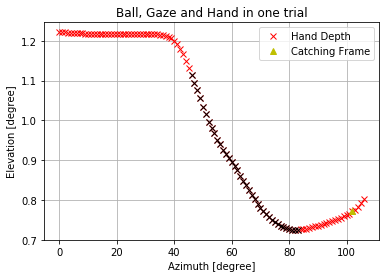

In [9]:
trialNumber = 2
print(trialInfoDataFrame.ballCaughtQ.values[trialNumber])
start = trialInfoDataFrame.trialStartIdx.values[trialNumber]
print(start)
end = trialInfoDataFrame.ballCrossingIndex.values[trialNumber]
print(end)
print(processedDataFrame.handAngularPos.Z.values[end])

frameRange = range(start,end+5)
plt.figure()
#plt.errorbar(x, meanHandX, yerr=stdHandX, fmt='--bo', ecolor='b', label = 'Hand X')
#plt.plot(np.arange(len(frameRange)), rawDataFrame.ballPos.Z.values[frameRange] - rawDataFrame.viewPos.Z.values[frameRange],'ob', label = 'Ball Depth')
plt.plot(np.arange(len(frameRange)), processedDataFrame.handAngularPos.Z.values[frameRange],'xr', label = 'Hand Depth')
#plt.plot(processedDataFrame.handAngularPos.X.values[frameRange], processedDataFrame.handAngularPos.Y.values[frameRange],'*g', label = 'Hand')

on = trialInfoDataFrame.ballOnIdx.values[trialNumber]
off = trialInfoDataFrame.ballOffIdx.values[trialNumber]

frameRange = range(off,on)
#plt.plot(np.arange(len(frameRange)), rawDataFrame.ballPos.Z.values[frameRange] - rawDataFrame.viewPos.Z.values[frameRange],'ok')
plt.plot(np.arange(len(frameRange))+ off-start, processedDataFrame.handAngularPos.Z.values[frameRange],'xk')
plt.plot(end-start, processedDataFrame.handAngularPos.Z.values[end],'^y', label = 'Catching Frame')



plt.grid(True)
plt.legend()
plt.title("Ball, Gaze and Hand in one trial")
plt.xlabel('Azimuth [degree]')
plt.ylabel('Elevation [degree]')
plt.show()

In [10]:
import transformations as Transformation

In [11]:
angles = np.empty((1,3))
for item in rawDataFrame.viewQuat.values[600:900]:
    #print(angles)
    #print(np.array(Transformation.euler_from_quaternion([item[3], item[0], item[1], item[2]])))
    angles = np.vstack((angles, (180/np.pi)*np.array(Transformation.euler_from_quaternion([item[3], item[0], item[1], item[2]]))))
angles = np.delete(angles,0,0)
print(angles.shape)

(300, 3)


703


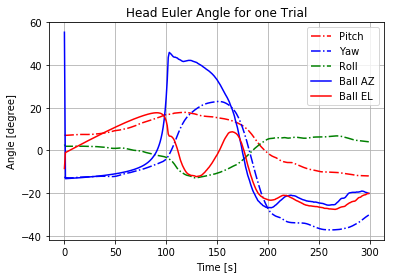

In [12]:
end = trialInfoDataFrame.ballCrossingIndex.values[2]
print(end)
plt.figure()
plt.plot(np.arange(angles.shape[0]), -angles[:,0],'-.r', label = 'Pitch')
plt.plot(np.arange(angles.shape[0]), angles[:,1],'-.b', label = 'Yaw')
plt.plot(np.arange(angles.shape[0]), angles[:,2],'-.g', label = 'Roll')

x = (180 / np.pi)*np.arctan(processedDataFrame.ballOnScreen.X.values.astype(float)/eyeToScreenDistance)
y = (180 / np.pi)*np.arctan(processedDataFrame.ballOnScreen.Y.values.astype(float)/eyeToScreenDistance)
xg = (180 / np.pi)*np.arctan(processedDataFrame.gazePoint.X.values.astype(float)/eyeToScreenDistance)
yg = (180 / np.pi)*np.arctan(processedDataFrame.gazePoint.Y.values.astype(float)/eyeToScreenDistance)

plt.plot(np.arange(angles.shape[0]), x[600:900],'b', label = 'Ball AZ')
plt.plot(np.arange(angles.shape[0]), y[600:900],'r', label = 'Ball EL')

plt.grid(True)
plt.legend()
plt.title("Head Euler Angle for one Trial")
plt.xlabel('Time [s]')
plt.ylabel('Angle [degree]')
plt.show()

In [15]:
fileTimeList = ['2016-4-19-14-4']
integrationLength = 45
for subjectID in fileTimeList:
    
    pickleFileName = r'.\Datasets\\'+subjectID+'\\DataSet_All-'+ subjectID +'.pickle'

    print('Reading Data Set File ... \n ', pickleFileName)
    eyeToScreenDistance = 0.0725
    ballDiameter = 0.01
    rawAllDataSet = pd.read_pickle(pickleFileName)


Reading Data Set File ... 
  .\Datasets\\2016-4-19-14-4\DataSet_All-2016-4-19-14-4.pickle


tr_70_type_t1


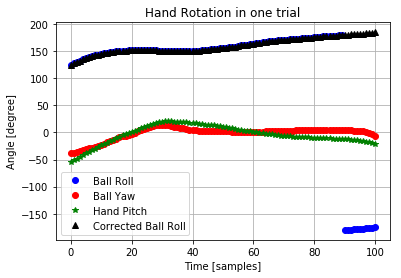

In [25]:
tr = 70
myKeys = list(rawAllDataSet.keys())
print(myKeys[tr])
rawAllDataSet[myKeys[tr]].shape

myDataSet = rawAllDataSet[myKeys[tr]]

plt.figure()
plt.plot(np.arange(len(myDataSet[:,5])), myDataSet[:,5],'ob', label = 'Ball Roll')
plt.plot(np.arange(len(myDataSet[:,6])), myDataSet[:,6],'or', label = 'Ball Yaw')
plt.plot(np.arange(len(myDataSet[:,7])), myDataSet[:,7],'*g', label = 'Hand Pitch')

A = myDataSet[:,5]
A[A<-90] = A[A<-90] + 360
myDataSet[:,5] = A
plt.plot(np.arange(len(myDataSet[:,5])), myDataSet[:,5],'^k', label = 'Corrected Ball Roll')

plt.grid(True)
plt.legend()
plt.title("Hand Rotation in one trial")
plt.xlabel('Time [samples]')
plt.ylabel('Angle [degree]')
#plt.savefig(str(Q)+'SampleTrial'+str(trialNumber)+'.png', dpi=600)
plt.show()

In [27]:
a = np.zeros(1)

In [28]:
a

array([ 0.])

In [31]:
a = np.vstack((a,'asbds'))

In [32]:
a

array([['0.0'],
       ['asbds']],
      dtype='<U32')

In [34]:
a = np.delete(a,0)

In [35]:
a

array(['asbds'],
      dtype='<U32')

In [37]:
a.append('c')

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
import matplotlib.pyplot as plt

xData1 = []
yData1 = []
plt.figure()
#plt.errorbar(x, meanHandX, yerr=stdHandX, fmt='--bo', ecolor='b', label = 'Hand X')
plt.plot(xData1, yData1,'ob', label = 'Label_1')
plt.plot(xData2, yData2,'xr', label = 'Label_2')
plt.plot(xData3, yData3,'*g', label = 'Label_3')

#plt.grid(True)
plt.legend()
#plt.title("Ball, Gaze and Hand in one trial")
plt.xlabel('plot X Label')
plt.ylabel('plot Y Label')
plt.savefig('samplePlot.png', dpi=600)
plt.show()